In [102]:
## Import methods
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix
from scipy import stats

from Process_data import Process_Data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Pipeline-ish
- read data into dataframe
- replace NaNs with zeros
- PCA down to 2 features

In [99]:
class Process_Data(object):
    '''Process data for clustering

    load the data into a datafram
    replace Nans with zeros
    repalce
    pca/lstne down, put results in a different dataframe

    '''

    def __init__(self, filepath=None):
        self.filepath = filepath
        self.df = pd.DataFrame([])
        self.df_pca = pd.DataFrame([])
        self.df_tsne = pd.DataFrame([])

    def _load_data(self):
        self.df = pd.read_csv(self.filepath, sep='\t')

    def _format_data(self):
        #replace Nans with zeros
        self.df.fillna(0, inplace=True)
        #make a column with rolling4Q sum
        self.df['R4Q Total'] = self.df.iloc[:,-4:].sum(axis=1)
        #drop funds where rolling4Q sum <1
        self.df = self.df[self.df['R4Q Total']>=1]

    def _pca(self):
        '''
        Find pca for numerical columns
        Output: assign for self.df_pca a copy of input dataframe with
                pca columns appended
        '''
        pca = PCA(n_components = 2)
        self.df_pca = self.df.copy()
        #use only the numeric columns
        numerical_df = self.df_pca.select_dtypes(include=[np.number])


        pca_result = pca.fit_transform(numerical_df.values)
        self.df_pca['pca_one'] = pca_result[:,0]
        self.df_pca['pca_two'] = pca_result[:,1]

    def _tsne(self):
        '''
        Find tsne for numerical columns
        Output: assign for self.df_tsne a copy of input dataframe with
                tsne columns appended
        '''
        tsne = TSNE(n_components = 2)
        self.df_tsne = self.df.copy()
        #use only the numeric columns
        numerical_df = self.df_tsne.select_dtypes(include=[np.number])


        tsne_result = tsne.fit_transform(numerical_df.values)
        self.df_tsne['tsne_one'] = tsne_result[:,0]
        self.df_tsne['tsne_two'] = tsne_result[:,1]


    def _plot_lower_dims(self, dim_red = 'pca'):
        '''
        plot the features in lower-dimensional space
        dim_red: the dimensionality reduction type to plot. Can be 'pca' or 'tsne'
        '''
        if dim_red == 'pca':
            pca_one = self.df_pca['pca_one']
            pca_two = self.df_pca['pca_two']
            plt.scatter(pca_one.values, pca_two.values)

        elif dim_red == 'tsne':
            tsne_one = self.df_tsne['tsne_one']
            tsne_two = self.df_tsne['tsne_two']
            plt.scatter(tsne_one.values, tsne_two.values)
        plt.show()


In [159]:
df_cusip_bd = pd.read_csv('data_dump-20180220.txt', sep='\t')
df_mstar = pd.read_csv('MS 20170116 - LMS Data Pull - 2017 Q4.txt', sep='\t', encoding = "ISO-8859-1")

df_cusip_bd.fillna(0, inplace=True)
df_mstar.fillna(0, inplace=True)

df_cusip_bd_fundid=df_cusip_bd.merge(df_mstar, on='CUSIP')

columnstokeep=['Client ID','FundId','Fund Standard Name','Morningstar Category', 'Broad Category Group', 'Q1 2017 SALES',
               'Q2 2017 SALES', 'Q3 2017 SALES', 'Q4 2017 SALES']
df_funds = df_cusip_bd_fundid.loc[:,columnstokeep]
df_funds_sum = df_funds.groupby(['FundId','Client ID','Fund Standard Name','Morningstar Category', 'Broad Category Group']).sum()
df_funds_sum['R4Q Total'] = df_funds_sum.iloc[:,-4:].sum(axis=1)
df_funds_sum = df_funds_sum[df_funds_sum['R4Q Total']>=1]
df_funds_sum = df_funds_sum.reset_index()
df_funds_sum.head()

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,R4Q Total
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,2.161413e+08,2.215168e+08,2.086214e+08,1.898351e+08,8.361147e+08
1,FS00008L4C,BLACKROCK,BlackRock Advantage Emerging Markets Fd,US Fund Diversified Emerging Mkts,Equity,3.654091e+06,3.060467e+06,5.985218e+05,2.755062e+06,1.006814e+07
2,FS00008L4E,BLACKROCK,BlackRock Commodity Strategies Portfolio,US Fund Commodities Broad Basket,Commodities,2.333894e+07,1.458536e+07,1.875160e+07,2.705834e+07,8.373424e+07
3,FS00008L4F,BLACKROCK,BlackRock Global Long/Short Credit Fund,US Fund Long-Short Credit,Alternative,1.703580e+08,1.280911e+08,1.071659e+08,9.590984e+07,5.015248e+08
4,FS00008L4J,FTEMPLETON,Templeton Emerging Markets Balanced Fund,US Fund Diversified Emerging Mkts,Equity,1.120218e+06,1.961528e+06,1.812875e+06,1.912762e+06,6.807383e+06


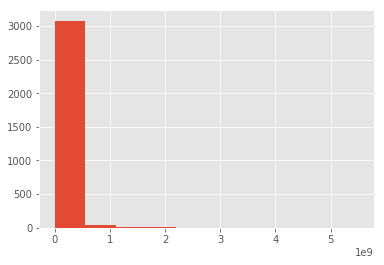

In [93]:
df_funds_sum['Q1 2017 SALES'].hist()

In [83]:
p = Process_Data()
p.df = df_funds_sum[df_funds_sum['Broad Category Group']=='Allocation']
p._pca()
p._tsne()

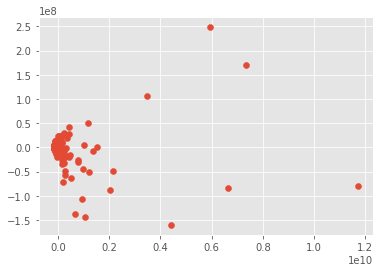

In [84]:
p._plot_lower_dims(dim_red='pca')

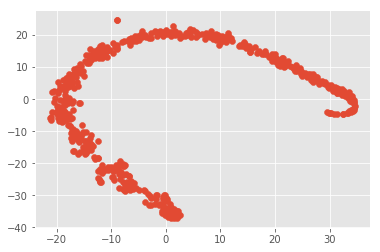

In [86]:
tsne_one = p.df_tsne['pca_one']
tsne_two = p.df_tsne['pca_two']
plt.scatter(tsne_one.values, tsne_two.values)

In [87]:
p.df_tsne.head()

,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,R4Q Total,pca_one,pca_two
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,2.161413e+08,2.215168e+08,2.086214e+08,1.898351e+08,8.361147e+08,34.464924,-2.712164
6,FS00008LFA,EATONVANCE,Eaton Vance Multi-Strategy All Mkt Fund,US Fund World Allocation,Allocation,1.158545e+06,7.030516e+05,3.362010e+05,3.142586e+05,2.512056e+06,-19.756351,2.576609
8,FS00008LPC,EATONVANCE,Eaton Vance Rich Bern All Asst Strat Fd,US Fund Tactical Allocation,Allocation,5.259961e+07,4.489969e+07,3.308944e+07,3.669511e+07,1.672839e+08,27.713924,5.752687
23,FS00008NAY,TRANSAMERICA,Transamerica Dynamic Income Fund,US Fund Allocation--15% to 30% Equity,Allocation,6.154551e+06,5.677708e+06,2.933025e+06,2.784109e+06,1.754939e+07,-0.610395,21.100452
34,FS00008TIG,NUVEEN,TIAA-CREF Lifestyle Aggressive Gr Fund,US Fund Allocation--85%+ Equity,Allocation,4.341681e+04,2.627040e+03,2.615746e+04,8.771140e+03,8.097245e+04,-7.349961,-27.536039


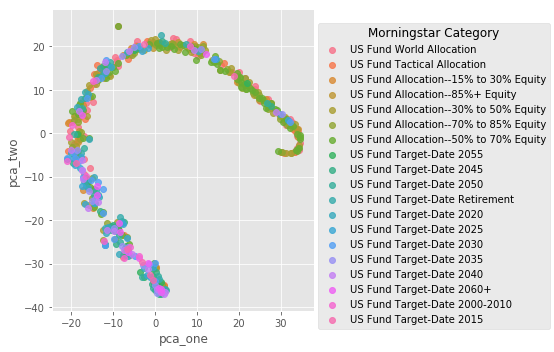

In [88]:
sns.lmplot(x='pca_one', y ='pca_two', data = p.df_tsne, hue = 'Morningstar Category', fit_reg=False)

In [95]:
p2 = Process_Data()
p2.df = df_funds_sum
p2._pca()
p2._tsne()

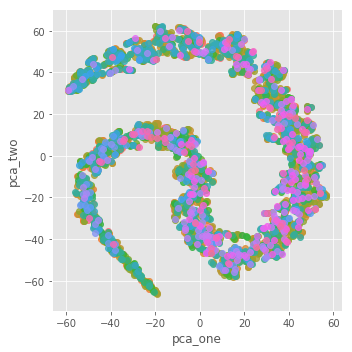

In [182]:
sns.lmplot(x='pca_one', y ='pca_two', data = p2.df_tsne, hue = 'Morningstar Category', fit_reg=False, legend=False)

# try:
- using 3 dims for tsne
- % diff

In [104]:
'''
Find tsne for numerical columns
Output: assign for self.df_tsne a copy of input dataframe with
tsne columns appended
'''
tsne3 = TSNE(n_components = 3)
df_tsne3 = df_funds_sum.copy()
#use only the numeric columns
numerical_df = df_tsne3.select_dtypes(include=[np.number])

tsne_result3 = tsne3.fit_transform(numerical_df.values)


In [109]:
df_tsne3['tsne_one'] = tsne_result3[:,0]
df_tsne3['tsne_two'] = tsne_result3[:,1]
df_tsne3['tsne_three'] = tsne_result3[:,2]
df_tsne3.head()

,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,R4Q Total,tsne_one,tsne_two,tsne_three
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,2.161413e+08,2.215168e+08,2.086214e+08,1.898351e+08,8.361147e+08,-11.783949,-13.045665,5.595779
1,FS00008L4C,BLACKROCK,BlackRock Advantage Emerging Markets Fd,US Fund Diversified Emerging Mkts,Equity,3.654091e+06,3.060467e+06,5.985218e+05,2.755062e+06,1.006814e+07,12.992631,7.875742,3.610777
2,FS00008L4E,BLACKROCK,BlackRock Commodity Strategies Portfolio,US Fund Commodities Broad Basket,Commodities,2.333894e+07,1.458536e+07,1.875160e+07,2.705834e+07,8.373424e+07,-10.324808,6.705160,-2.401527
3,FS00008L4F,BLACKROCK,BlackRock Global Long/Short Credit Fund,US Fund Long-Short Credit,Alternative,1.703580e+08,1.280911e+08,1.071659e+08,9.590984e+07,5.015248e+08,-6.434473,-18.941124,0.025250
4,FS00008L4J,FTEMPLETON,Templeton Emerging Markets Balanced Fund,US Fund Diversified Emerging Mkts,Equity,1.120218e+06,1.961528e+06,1.812875e+06,1.912762e+06,6.807383e+06,7.803970,8.837029,-2.426242


In [180]:
# sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne3, hue = 'Morningstar Category', fit_reg=False)

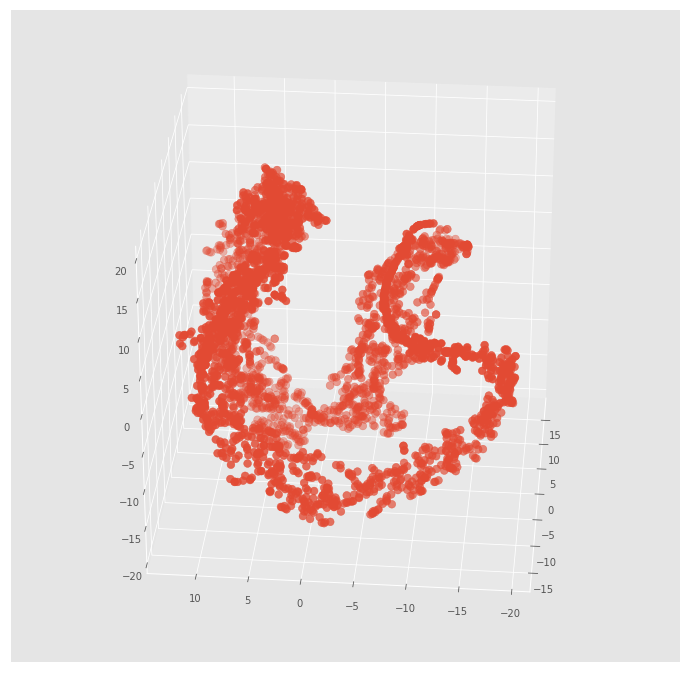

In [117]:
from mpl_toolkits.mplot3d import Axes3D
# plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
colors = df_tsne3['Morningstar Category'].values
ax.scatter(df_tsne3['tsne_one'], df_tsne3['tsne_two'], df_tsne3['tsne_three'], s=60)
ax.view_init(30, 185)
plt.show()

# convert the fund sales/reds to % change

In [158]:
df_funds_sum.columns

Index(['FundId', 'Client ID', 'Fund Standard Name', 'Morningstar Category',
       'Broad Category Group', 'Q2 2017 SALES % Change',
       'Q3 2017 SALES % Change', 'Q4 2017 SALES % Change'],
      dtype='object')

In [161]:
df_funds_sum.head()
def make_pct_change(df, list_col_names_to_change):
    '''
   
    '''
    # Filter the dataframe to just the columns to change
    df=df.copy()
    df_to_change = df.loc[:,list_col_names_to_change]
    num_columns = df_to_change.shape[1]
    
    # got through columns t+1 to end
    for col_idx in np.arange(1,num_columns):
        col_name = ('{} % Change'.format(df_to_change.iloc[:,col_idx].name))
        df[col_name]=(df_to_change.iloc[:,col_idx]-df_to_change.iloc[:,col_idx-1])/df_to_change.iloc[:,col_idx-1]
    
    return df

In [172]:
df_funds_pct_change = make_pct_change(df_funds_sum, ['Q1 2017 SALES', 'Q2 2017 SALES','Q3 2017 SALES', 'Q4 2017 SALES'])
# drop the raw columns
df_funds_pct_change.drop(['Q1 2017 SALES', 'Q2 2017 SALES',
       'Q3 2017 SALES', 'Q4 2017 SALES', 'R4Q Total'], axis=1, inplace=True)
# deal with infinite and nan entries caused by dividing by 0 or a very small amount
df_funds_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_funds_pct_change.fillna(0, inplace=True)
df_funds_pct_change.head()

,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q2 2017 SALES % Change,Q3 2017 SALES % Change,Q4 2017 SALES % Change
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,0.024870,-0.058214,-0.090050
1,FS00008L4C,BLACKROCK,BlackRock Advantage Emerging Markets Fd,US Fund Diversified Emerging Mkts,Equity,-0.162455,-0.804434,3.603110
2,FS00008L4E,BLACKROCK,BlackRock Commodity Strategies Portfolio,US Fund Commodities Broad Basket,Commodities,-0.375063,0.285645,0.442989
3,FS00008L4F,BLACKROCK,BlackRock Global Long/Short Credit Fund,US Fund Long-Short Credit,Alternative,-0.248106,-0.163362,-0.105034
4,FS00008L4J,FTEMPLETON,Templeton Emerging Markets Balanced Fund,US Fund Diversified Emerging Mkts,Equity,0.751023,-0.075784,0.055099


In [173]:
df_funds_pct_change.describe()

,Q2 2017 SALES % Change,Q3 2017 SALES % Change,Q4 2017 SALES % Change
count,3134.000000,3134.000000,3134.000000
mean,345.881519,2.872713,2.187681
std,15421.447245,134.012468,34.469761
min,-6.566801,-3.352646,-11.053939
25%,-0.369398,-0.354280,-0.197556
50%,-0.108370,-0.123864,0.030086
75%,0.213131,0.121836,0.397620
max,833332.333333,7494.625000,1509.428571


In [174]:
tsne_pct = TSNE(n_components = 2)
df_tsne_pct = df_funds_pct_change.copy()
#use only the numeric columns
numerical_df = df_tsne_pct.select_dtypes(include=[np.number])

tsne_result_pct = tsne_pct.fit_transform(numerical_df.values)

In [175]:
df_tsne_pct['tsne_one'] = tsne_result_pct[:,0]
df_tsne_pct['tsne_two'] = tsne_result_pct[:,1]
df_tsne_pct.head()

,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q2 2017 SALES % Change,Q3 2017 SALES % Change,Q4 2017 SALES % Change,tsne_one,tsne_two
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,0.024870,-0.058214,-0.090050,-9.475331,21.495438
1,FS00008L4C,BLACKROCK,BlackRock Advantage Emerging Markets Fd,US Fund Diversified Emerging Mkts,Equity,-0.162455,-0.804434,3.603110,12.345740,-51.869122
2,FS00008L4E,BLACKROCK,BlackRock Commodity Strategies Portfolio,US Fund Commodities Broad Basket,Commodities,-0.375063,0.285645,0.442989,23.425421,-3.909065
3,FS00008L4F,BLACKROCK,BlackRock Global Long/Short Credit Fund,US Fund Long-Short Credit,Alternative,-0.248106,-0.163362,-0.105034,4.399293,29.074001
4,FS00008L4J,FTEMPLETON,Templeton Emerging Markets Balanced Fund,US Fund Diversified Emerging Mkts,Equity,0.751023,-0.075784,0.055099,-27.158667,-25.524513


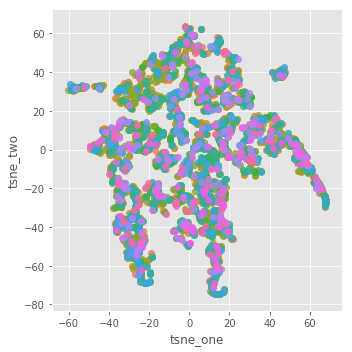

In [181]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_pct, hue = 'Morningstar Category', fit_reg=False, legend=False)

In [ ]:
# Try to take out the time component

In [ ]:
# try clustering in high-dimensional space.
# feature engineer so that jan fun 1- avg jan all funds
# dynamic time warping - use dtw as the distance metric hierachical clustering lecture
# 